Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
!git clone https://github.com/google-research/google-research.git

In [1]:
import sys
import os
import tarfile
import urllib
import zipfile

# sys.path.append('./google-research')

# Examples of streaming and non streaming inference with TF/TFlite

## Imports

In [3]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.models import utils
from kws_streaming.layers.modes import Modes
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models import model_flags
from kws_streaming.models import model_params
from kws_streaming.train import test
from kws_streaming import data

config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)

# general imports
import matplotlib.pyplot as plt
import os
import json
from IPython import display
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal
import tensorflow_io as tfio
tf1.disable_eager_execution()

tf.__version__

tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

## Load wav file

In [4]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  with tf.io.gfile.GFile(filename, 'rb') as file_handle:
    samplerate, wave_data = wav.read(file_handle)
  # Read in wav file.
  return wave_data, samplerate

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
      round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [5]:
# set PATH to data sets (for example to speech commands V2):
# it can be downloaded from
# https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# if you run 00_check-data.ipynb then data2 should be located in the current folder
current_dir = 'C:/Users/alien/Documents/PyCharm-Projects/keyword-transformer/'
DATA_PATH = os.path.join(current_dir, "data2/")

In [6]:
samplerate = 16000
# read audio file
audio, _ = tf.audio.decode_wav(tf.io.read_file('C:/Users/alien/Documents/PyCharm-Projects/keyword-transformer/s1_test_release/s1_test_0000.wav'))
waveform = tf.squeeze(audio, axis=-1)


In [ ]:
# for simple test instead of reading wav - just generate cos
# samplerate = 16000
# wav_data = np.cos(2.0*np.pi*8.0*np.arange(samplerate)/samplerate)

In [ ]:
#assert samplerate == 16000
#sound.Play(wav_data, samplerate)

In [7]:
plt.plot(waveform.numpy())

AttributeError: 'Tensor' object has no attribute 'numpy'

## Prepare batched model

In [13]:
# Set path to model weights and model parameters models trained on data set V2 can be downloaded from
# https://storage.googleapis.com/kws_models/models2.zip
# or from https://storage.googleapis.com/kws_models/models2_30k.zip
MODEL_URL = "https://storage.googleapis.com/kws_models/models2_30k.zip"
# base_name = os.path.basename(MODEL_URL)
MODELS_PATH = 'C:/Users/alien/Documents/PyCharm-Projects/keyword-transformer/models_data_v2_12_labels/97.65625/'
# base_name

In [ ]:
# it can take some time to download 2.3GB. After unpacking total size is 5.4GB
# arch_file_name = os.path.join(MODELS_PATH, base_name)
# if not os.path.isfile(arch_file_name):
#   # download data
#   if sys.version_info >= (2, 5):
#     file_path = urllib.request.urlretrieve(MODEL_URL, filename=arch_file_name)[0]
#   else:
#     file_path = urllib.urlretrieve(MODEL_URL, filename=arch_file_name)[0]
#
#   # unpack it
#   file_name, file_extension = os.path.splitext(base_name)
#   with zipfile.ZipFile(file_path, 'r') as zip_ref:
#     zip_ref.extractall(MODELS_PATH)

In [17]:
# train_dir = os.path.join(MODELS_PATH, file_name, 'svdf')
# urllib.request.urlretrieve(MODEL_URL, filename='C:/Users/alien/Documents/PyCharm-Projects/keyword-transformer/models2.zip')[0]

In [14]:
# load command line command flags which were use for model creation/training
from argparse import Namespace
with open(os.path.join(MODELS_PATH, 'flags.txt'), 'r') as fd:
  flags_txt = fd.read()
flags = eval(flags_txt)

In [ ]:
# below is another way of reading flags - through json
# with tf.compat.v1.gfile.Open(os.path.join(train_dir, 'flags.json'), 'r') as fd:
#   flags_json = json.load(fd)

# class DictStruct(object):
#   def __init__(self, **entries):
#     self.__dict__.update(entries)

# flags = DictStruct(**flags_json)


In [15]:
flags.data_dir = DATA_PATH

In [16]:
# pad input audio with zeros, so that audio len = flags.desired_samples
zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
# Concatenate audio with padding so that all audio clips will be of the same length
waveform = tf.cast(waveform, tf.float32)
equal_length = tf.concat([waveform, zero_padding], 0)
input_data = tf.expand_dims(equal_length, 0)

In [17]:
# prepare mapping of index to word
audio_processor = data.input_data.AudioProcessor(flags)
index_to_label = {}
# labels used for training
for word in audio_processor.word_to_index.keys():
  if audio_processor.word_to_index[word] == data.input_data.SILENCE_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = data.input_data.SILENCE_LABEL
  elif audio_processor.word_to_index[word] == data.input_data.UNKNOWN_WORD_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = data.input_data.UNKNOWN_WORD_LABEL
  else:
    index_to_label[audio_processor.word_to_index[word]] = word

# training labels
index_to_label

{2: 'bird',
 3: 'eight',
 4: 'falcon',
 5: 'five',
 6: 'four',
 7: 'nine',
 8: 'one',
 9: 'seven',
 10: 'six',
 11: 'snake',
 12: 'three',
 13: 'two',
 14: 'zero',
 0: '_silence_'}

In [ ]:
# we can create a dummy model
# flags = model_params.HOTWORD_MODEL_PARAMS['gru']
# flags = model_flags.update_flags(flags)

In [18]:
# create model with flag's parameters
model_non_stream_batch = models.MODELS[flags.model_name](flags)

# load model's weights
weights_name = 'best_weights'
model_non_stream_batch.load_weights(os.path.join(MODELS_PATH, weights_name))

c:\program files\python38\lib\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: Default value of `approximate` is changed from `True` to `False`
  return py_builtins.overload_of(f)(*args)


In [ ]:
#model_non_stream_batch.summary()

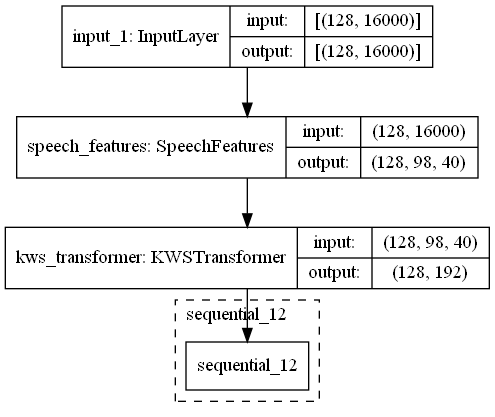

In [19]:
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True, to_file='model.png')

## Run inference with TF

### TF Run non streaming inference

In [27]:
# convert model to inference mode with batch one
inference_batch_size = 1
tf.keras.backend.set_learning_phase(0)
flags.batch_size = inference_batch_size  # set batch size
model_non_stream_batch.summary()
# model_non_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
# model_non_stream.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 16000)]            0         
_________________________________________________________________
speech_features (SpeechFeatu (128, 98, 40)             0         
_________________________________________________________________
kws_transformer (KWSTransfor (128, 192)                5358528   
_________________________________________________________________
sequential_12 (Sequential)   multiple                  2895      
Total params: 5,361,423
Trainable params: 5,361,423
Non-trainable params: 0
_________________________________________________________________


c:\program files\python38\lib\site-packages\tensorflow\python\keras\backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [22]:
# tf.keras.utils.plot_model(
#     model_non_stream,
#     show_shapes=True,
#     show_layer_names=True,
#     expand_nested=True, to_file='model.png')

NameError: name 'model_non_stream' is not defined

In [29]:
predictions = model_non_stream_batch.predict(input_data, steps=128)
predicted_labels = np.argmax(predictions, axis=1)

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Input to reshape is a tensor with 16000 values, but the requested shape has 2048000
	 [[{{node speech_features/data_frame/frame/Reshape}}]]
	 [[sequential_12/dense_73/BiasAdd/_333]]
  (1) Invalid argument: Input to reshape is a tensor with 16000 values, but the requested shape has 2048000
	 [[{{node speech_features/data_frame/frame/Reshape}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
predicted_labels

In [ ]:
index_to_label[predicted_labels[0]]

### TF Run streaming inference with internal state

In [ ]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_INTERNAL_STATE_INFERENCE)
#model_stream.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:
# run streaming inference
start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end]

  # get new frame from stream of data
  stream_output_prediction = model_stream.predict(stream_update)
  stream_output_arg = np.argmax(stream_output_prediction)

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

stream_output_arg

In [ ]:
index_to_label[stream_output_arg]

### TF Run streaming inference with external state

In [ ]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
#model_stream.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:

inputs = []
for s in range(len(model_stream.inputs)):
  inputs.append(np.zeros(model_stream.inputs[s].shape, dtype=np.float32))

reset_state = True

if reset_state:
  for s in range(len(model_stream.inputs)):
    inputs[s] = np.zeros(model_stream.inputs[s].shape, dtype=np.float32)

start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  # get new frame from stream of data
  stream_update = input_data[:, start:end]

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

  # set input audio data (by default input data at index 0)
  inputs[0] = stream_update

  # run inference
  outputs = model_stream.predict(inputs)

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(model_stream.inputs)):
    inputs[s] = outputs[s]

  stream_output_arg = np.argmax(outputs[0])
stream_output_arg

In [ ]:
index_to_label[stream_output_arg]

## Run inference with TFlite

### Run non streaming inference with TFLite

In [49]:
path = os.path.join('C:/Users/alien/Documents/PyCharm-Projects/keyword-transformer/models_data_v2_12_labels/96.5625/tflite_non_stream')
tflite_model_name = 'non_stream.tflite'

# tflite_non_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.NON_STREAM_INFERENCE)

# prepare TFLite interpreter
with open(os.path.join(path, tflite_model_name), 'rb') as f:
  model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [53]:
# pad input audio with zeros, so that audio len = flags.desired_samples
zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
# Concatenate audio with padding so that all audio clips will be of the same length
waveform = tf.cast(waveform, tf.float32)
equal_length = tf.concat([waveform, zero_padding], 0)
input_data = tf.expand_dims(equal_length, 0)

AttributeError: 'Tensor' object has no attribute 'numpy'

In [55]:
# set input audio data (by default input data at index 0)
interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))

# run inference
interpreter.invoke()

# get output: classification
out_tflite = interpreter.get_tensor(output_details[0]['index'])

out_tflite_argmax = np.argmax(out_tflite)

out_tflite_argmax

AttributeError: 
        'Tensor' object has no attribute 'astype'.
        If you are looking for numpy-related methods, please run the following:
        import tensorflow.python.ops.numpy_ops.np_config
        np_config.enable_numpy_behavior()

In [ ]:
print(out_tflite)

In [ ]:
index_to_label[out_tflite_argmax]

### Run streaming inference with TFLite

In [ ]:
# path = os.path.join(train_dir, 'tflite_stream_state_external')
# tflite_model_name = 'stream_state_external.tflite'

tflite_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)

In [ ]:
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [ ]:
input_details[0]['shape']

In [ ]:
reset_state = True

# before processing new test sequence we can reset model state
# if we reset model state then it is not real streaming mode
if reset_state:
  for s in range(len(input_details)):
    print(input_details[s]['shape'])
    inputs[s] = np.zeros(input_details[s]['shape'], dtype=np.float32)

start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end]
  stream_update = stream_update.astype(np.float32)

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

  # set input audio data (by default input data at index 0)
  interpreter.set_tensor(input_details[0]['index'], stream_update)

  # set input states (index 1...)
  for s in range(1, len(input_details)):
    interpreter.set_tensor(input_details[s]['index'], inputs[s])

  # run inference
  interpreter.invoke()

  # get output: classification
  out_tflite = interpreter.get_tensor(output_details[0]['index'])
  #print(start / 16000.0, np.argmax(out_tflite), np.max(out_tflite))

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(input_details)):
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    inputs[s] = interpreter.get_tensor(output_details[s]['index'])

  out_tflite_argmax = np.argmax(out_tflite)
out_tflite_argmax

In [ ]:
print(out_tflite)

In [ ]:
index_to_label[out_tflite_argmax]